<a href="https://colab.research.google.com/github/gabriellamarinho/predicao_de_irrigacao/blob/main/predi%C3%A7%C3%A3o_de_irriga%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sobre a base de dados:


Descrição da Base de Dados

A base de dados reúne informações de um sistema de irrigação automatizado, com o objetivo de prever se a água deve estar ligada (1) ou desligada (0). Ela inclui dados como umidade do solo, temperatura, horário, e estado de sensores, permitindo que o sistema acione automaticamente a bomba d’água conforme a necessidade.

dataset disponivel em:

https://www.kaggle.com/datasets/nelakurthisudheer/dataset-for-predicting-watering-the-plants


### Importar a base de dados:


In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
%reset -f

In [153]:


!pip install feature-engine

In [233]:

# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e Normalização
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
from sklearn.model_selection import StratifiedKFold, cross_val_score
from pandas.api.types import CategoricalDtype

# Divisão de Dados
from sklearn.model_selection import train_test_split

# Modelos de Classificação
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from feature_engine.outliers import Winsorizer

# Avaliação de Modelos
from sklearn.metrics import accuracy_score, recall_score

# Configurações de visualização do pandas
pd.options.display.float_format = '{:.2f}'.format #Formatação para duas casas decimais
pd.set_option('display.max_rows', None) #Mostrar todas as linhas
pd.set_option('display.max_columns', None) #Mostrar todas as colunas


In [155]:
file_path = '/content/drive/MyDrive/TARP.csv'
try:
    df = pd.read_csv(file_path)
    print("File loaded successfully!")
except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'")
    print("Please check the file path and ensure the file exists in your Google Drive.")

File loaded successfully!


In [156]:
df.describe()

,Soil Moisture,Temperature,Soil Humidity,Time,Air temperature (C),Wind speed (Km/h),Air humidity (%),Wind gust (Km/h),Pressure (KPa),ph,rainfall,N,P,K
count,100000.00,100000.00,100000.00,100000.00,23995.00,23995.00,23995.00,23995.00,23995.00,2200.00,2200.00,2200.00,2200.00,2200.00
mean,45.48,22.54,45.02,55.25,24.26,9.90,58.52,41.74,101.13,6.47,103.46,50.55,53.36,48.15
std,25.99,13.25,14.73,32.09,6.76,4.33,30.07,24.17,0.22,0.77,54.96,36.92,32.99,50.65
min,1.00,0.00,20.00,0.00,11.22,0.00,0.59,0.00,100.50,3.50,20.21,0.00,5.00,5.00
25%,23.00,11.00,32.00,28.00,18.58,6.83,33.98,21.82,100.98,5.97,64.55,21.00,28.00,20.00
50%,45.00,23.00,45.00,55.00,22.15,9.53,61.31,37.24,101.12,6.43,94.87,37.00,51.00,32.00
75%,68.00,34.00,58.00,83.00,29.59,12.46,86.36,59.28,101.26,6.92,124.27,84.25,68.00,49.00
max,90.00,45.00,70.00,110.00,45.56,31.36,96.00,133.33,101.86,9.94,298.56,140.00,145.00,205.00


In [157]:
print(df.head())
## ou dados.tail() pra mostrar os ultimos

   Soil Moisture  Temperature   Soil Humidity  Time  Air temperature (C)  \
0             54           22              70    21                19.52   
1             12           20              40   104                19.49   
2             34           26              35    62                19.47   
3              7           44              44    93                19.54   
4             50           38              23    92                19.61   

   Wind speed (Km/h)  Air humidity (%)  Wind gust (Km/h)  Pressure (KPa)   ph  \
0               2.13             55.04              6.30          101.50 6.50   
1               2.01             55.17             10.46          101.50 7.04   
2               1.90             55.30             14.63          101.51 7.84   
3               2.28             54.20             16.08          101.51 6.98   
4               2.66             53.09             17.52          101.51 7.63   

   rainfall     N     P     K Status  
0    202.94 90.00

In [158]:
df.shape


(100000, 15)

In [159]:
print(df.columns)

Index(['Soil Moisture', 'Temperature', ' Soil Humidity', 'Time',
       'Air temperature (C)', 'Wind speed (Km/h)', 'Air humidity (%)',
       'Wind gust (Km/h)', 'Pressure (KPa)', 'ph', 'rainfall', 'N', 'P', 'K',
       'Status'],
      dtype='object')


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Soil Moisture        100000 non-null  int64  
 1   Temperature          100000 non-null  int64  
 2    Soil Humidity       100000 non-null  int64  
 3   Time                 100000 non-null  int64  
 4   Air temperature (C)  23995 non-null   float64
 5   Wind speed (Km/h)    23995 non-null   float64
 6   Air humidity (%)     23995 non-null   float64
 7   Wind gust (Km/h)     23995 non-null   float64
 8   Pressure (KPa)       23995 non-null   float64
 9   ph                   2200 non-null    float64
 10  rainfall             2200 non-null    float64
 11  N                    2200 non-null    float64
 12  P                    2200 non-null    float64
 13  K                    2200 non-null    float64
 14  Status               100000 non-null  object 
dtypes: float64(10), in

LIMPEZA DE DADOS

In [161]:
# Verifica e remove linhas duplicadas
num_duplicadas = df.duplicated().sum()
print(f"Número de linhas duplicadas: {num_duplicadas}")

# Remove as linhas duplicadas (se desejar)
df = df.drop_duplicates()

Número de linhas duplicadas: 107


In [162]:
# Remove colunas totalmente vazias
df = df.dropna(axis=1, how='all')

# Preenche valores faltantes com a mediana das colunas numéricas de forma segura
for col in df.select_dtypes(include='number').columns:
    if df[col].isnull().sum() > 0:
        df.loc[:, col] = df[col].fillna(df[col].median())


In [163]:
percentual_nans = (df.isnull().sum() / len(df)) * 100
print(percentual_nans.sort_values(ascending=False))


Soil Moisture         0.00
Temperature           0.00
 Soil Humidity        0.00
Time                  0.00
Air temperature (C)   0.00
Wind speed (Km/h)     0.00
Air humidity (%)      0.00
Wind gust (Km/h)      0.00
Pressure (KPa)        0.00
ph                    0.00
rainfall              0.00
N                     0.00
P                     0.00
K                     0.00
Status                0.00
dtype: float64


Colunas numericas:

In [164]:
# Detectar numéricas excluindo binárias (0 e 1)
num_cols = [
    col for col in df.select_dtypes(include=['number']).columns
    if not set(df[col].dropna().unique()).issubset({0, 1})
]

print("Colunas numéricas sem variáveis binárias:")
print(num_cols)


Colunas numéricas sem variáveis binárias:
['Soil Moisture', 'Temperature', ' Soil Humidity', 'Time', 'Air temperature (C)', 'Wind speed (Km/h)', 'Air humidity (%)', 'Wind gust (Km/h)', 'Pressure (KPa)', 'ph', 'rainfall', 'N', 'P', 'K']


Colunas categoricas :

a coluna de status nao esta sendo indentificada como categorica aqui e vendo que ela é categorica e nao é indentificada em numerica, então definiremos aqui para garantir segurança

In [189]:
df['Status'] = df['Status'].astype('category')


In [190]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if cat_cols:
    print("Colunas identificadas como categóricas:")
    print(cat_cols)
else:
    print("Nenhuma coluna identificada como categórica.")


Colunas identificadas como categóricas:
['Status']


In [191]:
df['Status'] = df['Status'].astype('category')


In [192]:
print("Valores únicos:", df['Status'].unique())


Valores únicos: ['ON', 'OFF']
Categories (2, object): ['OFF', 'ON']


## Cálculo de medidas de tendência central: Média, mediana, moda para entender o valor típico dos dados.







media :

In [193]:
print(df.mean(numeric_only=True))

Soil Moisture          0.00
Temperature           -0.00
 Soil Humidity         0.00
Time                  55.25
Air temperature (C)   22.66
Wind speed (Km/h)     -0.00
Air humidity (%)       0.00
Wind gust (Km/h)      -0.00
Pressure (KPa)         0.00
ph                     0.00
rainfall              -0.00
N                      0.00
P                     -0.00
K                      0.00
dtype: float64


mediana:

In [194]:
print(df.median(numeric_only=True))

Soil Moisture         -0.02
Temperature            0.03
 Soil Humidity        -0.00
Time                  55.00
Air temperature (C)   22.15
Wind speed (Km/h)     -0.04
Air humidity (%)       0.05
Wind gust (Km/h)      -0.09
Pressure (KPa)        -0.03
ph                    -0.01
rainfall              -0.02
N                     -0.05
P                     -0.01
K                     -0.05
dtype: float64


moda:

In [195]:
print(df.mode(numeric_only=True))

   Soil Moisture  Temperature   Soil Humidity  Time  Air temperature (C)  \
0           0.90         0.26            0.68    99                22.15   

   Wind speed (Km/h)  Air humidity (%)  Wind gust (Km/h)  Pressure (KPa)  \
0              -0.04              0.05             -0.09           -0.03   

     ph  rainfall     N     P     K  
0 -0.01     -0.02 -0.05 -0.01 -0.05  


## Cálculo de medidas de dispersão: Desvio padrão, variância, amplitude para entender a variabilidade dos dados.

In [196]:
# Desvio padrão:
print(df.std(numeric_only=True))

# Desvio Padrão: Mede a dispersão dos dados em torno da média. Um desvio padrão alto indica maior variabilidade.

Soil Moisture          1.00
Temperature            1.00
 Soil Humidity         1.00
Time                  32.09
Air temperature (C)    3.43
Wind speed (Km/h)      1.00
Air humidity (%)       1.00
Wind gust (Km/h)       1.00
Pressure (KPa)         1.00
ph                     1.00
rainfall               1.00
N                      1.00
P                      1.00
K                      1.00
dtype: float64


In [197]:
# variancia :
print(df.var(numeric_only=True))


 #Variância: É o quadrado do desvio padrão e também mede a dispersão dos dados.

Soil Moisture            1.00
Temperature              1.00
 Soil Humidity           1.00
Time                  1029.95
Air temperature (C)     11.78
Wind speed (Km/h)        1.00
Air humidity (%)         1.00
Wind gust (Km/h)         1.00
Pressure (KPa)           1.00
ph                       1.00
rainfall                 1.00
N                        1.00
P                        1.00
K                        1.00
dtype: float64


In [198]:

print("--- Amplitude das Colunas Numéricas ---")

# Loop para calcular e exibir a amplitude apenas para as colunas em num_cols
for coluna in num_cols:
    # Verificação de segurança: garante que a coluna exista e seja realmente numérica
    if coluna in df.columns and pd.api.types.is_numeric_dtype(df[coluna]):
        amplitude = df[coluna].max() - df[coluna].min()
        print(f"Amplitude da coluna '{coluna}': {amplitude}")
    elif coluna in df.columns:
        print(f"Atenção: A coluna '{coluna}' (listada como numérica) não é um tipo numérico e sua amplitude não pode ser calculada desta forma.")
    else:
        print(f"Atenção: A coluna '{coluna}' não foi encontrada no seu arquivo CSV.")

print("\n--- Cálculo de Amplitude Concluído ---")

--- Amplitude das Colunas Numéricas ---
Amplitude da coluna 'Soil Moisture': 3.4240374799802376
Amplitude da coluna 'Temperature': 3.3958870461342707
Amplitude da coluna ' Soil Humidity': 3.3952833321468416
Amplitude da coluna 'Time': 110
Amplitude da coluna 'Air temperature (C)': 34.34
Amplitude da coluna 'Wind speed (Km/h)': 14.752154751651004
Amplitude da coluna 'Air humidity (%)': 6.4522693524072565
Amplitude da coluna 'Wind gust (Km/h)': 11.110350683546333
Amplitude da coluna 'Pressure (KPa)': 12.689855297470931
Amplitude da coluna 'ph': 55.90923181056144
Amplitude da coluna 'rainfall': 33.73447240690144
Amplitude da coluna 'N': 24.024775436119395
Amplitude da coluna 'P': 28.534318423564713
Amplitude da coluna 'K': 25.38231441055325

--- Cálculo de Amplitude Concluído ---


## Distribuição de classes

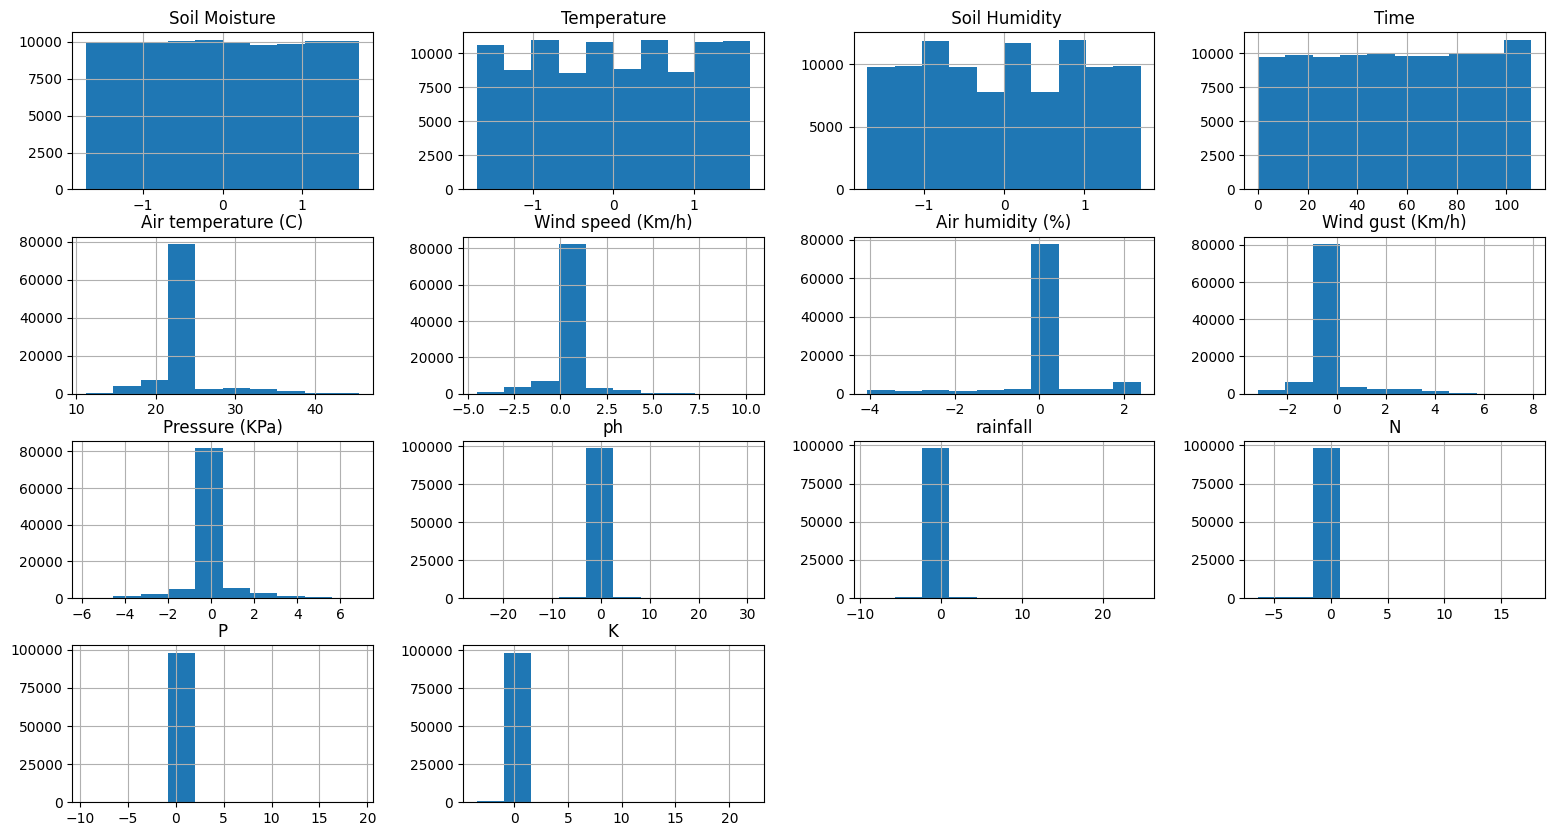


Distribuição da coluna 'Status':
Status
ON     53595
OFF    46298
Name: count, dtype: int64


In [199]:

# Histogramas das colunas numéricas
df.hist(figsize=(19, 10))
plt.show()

# Distribuição para colunas categóricas (detectando as colunas categoricas corretamente)
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for coluna in cat_cols:
    print(f"\nDistribuição da coluna '{coluna}':\n{df[coluna].value_counts()}")

In [200]:
for coluna in df.columns:
    contagem_unicos = len(df[coluna].unique())
    print(f"Total de valores únicos na coluna '{coluna}': {contagem_unicos}")

Total de valores únicos na coluna 'Soil Moisture': 90
Total de valores únicos na coluna 'Temperature': 46
Total de valores únicos na coluna ' Soil Humidity': 51
Total de valores únicos na coluna 'Time': 111
Total de valores únicos na coluna 'Air temperature (C)': 2878
Total de valores únicos na coluna 'Wind speed (Km/h)': 2257
Total de valores únicos na coluna 'Air humidity (%)': 8142
Total de valores únicos na coluna 'Wind gust (Km/h)': 4799
Total de valores únicos na coluna 'Pressure (KPa)': 137
Total de valores únicos na coluna 'ph': 2201
Total de valores únicos na coluna 'rainfall': 2201
Total de valores únicos na coluna 'N': 137
Total de valores únicos na coluna 'P': 117
Total de valores únicos na coluna 'K': 73
Total de valores únicos na coluna 'Status': 2


In [201]:
for coluna in df.columns:
    contagem = df[coluna].value_counts().sum()
    print(f"Total de valores na coluna '{coluna}': {contagem}")

Total de valores na coluna 'Soil Moisture': 99893
Total de valores na coluna 'Temperature': 99893
Total de valores na coluna ' Soil Humidity': 99893
Total de valores na coluna 'Time': 99893
Total de valores na coluna 'Air temperature (C)': 99893
Total de valores na coluna 'Wind speed (Km/h)': 99893
Total de valores na coluna 'Air humidity (%)': 99893
Total de valores na coluna 'Wind gust (Km/h)': 99893
Total de valores na coluna 'Pressure (KPa)': 99893
Total de valores na coluna 'ph': 99893
Total de valores na coluna 'rainfall': 99893
Total de valores na coluna 'N': 99893
Total de valores na coluna 'P': 99893
Total de valores na coluna 'K': 99893
Total de valores na coluna 'Status': 99893


variaveis que possuem alta correlação entre si :

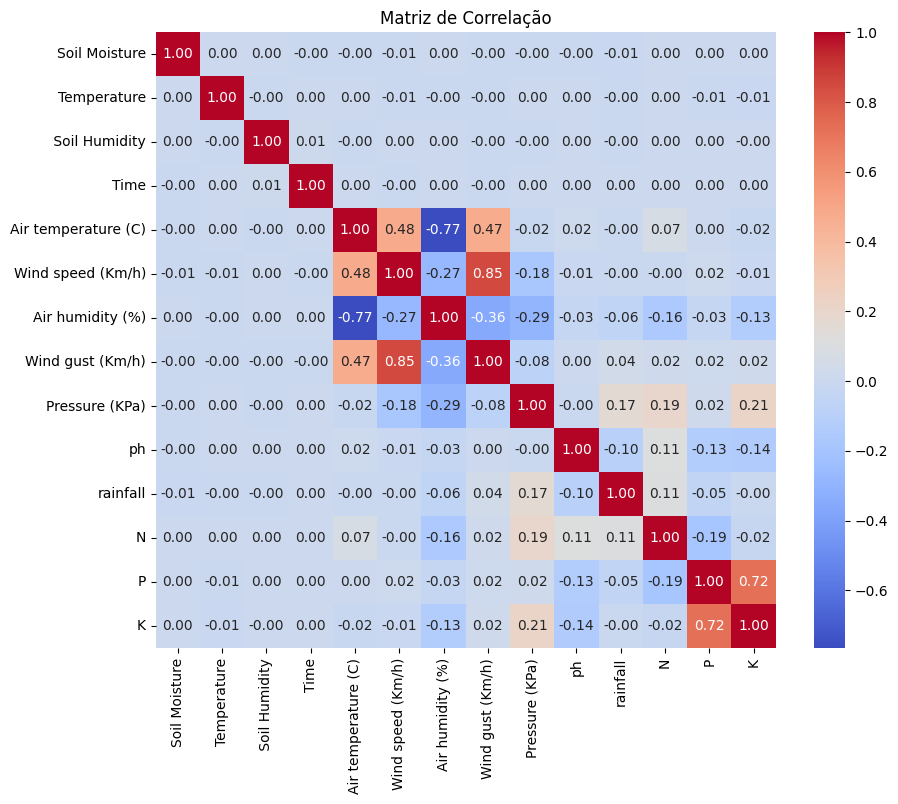

In [202]:
# Calcula a matriz de correlação
correlacao = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8)) # Ajusta o tamanho da figura para melhor visualização
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f") # fmt=".2f" formata os valores
plt.title('Matriz de Correlação')
plt.show()

In [203]:

print(correlacao)

                     Soil Moisture  Temperature   Soil Humidity  Time  \
Soil Moisture                 1.00         0.00            0.00 -0.00   
Temperature                   0.00         1.00           -0.00  0.00   
 Soil Humidity                0.00        -0.00            1.00  0.01   
Time                         -0.00         0.00            0.01  1.00   
Air temperature (C)          -0.00         0.00           -0.00  0.00   
Wind speed (Km/h)            -0.01        -0.01            0.00 -0.00   
Air humidity (%)              0.00        -0.00            0.00  0.00   
Wind gust (Km/h)             -0.00        -0.00           -0.00 -0.00   
Pressure (KPa)               -0.00         0.00           -0.00  0.00   
ph                           -0.00         0.00            0.00  0.00   
rainfall                     -0.01        -0.00           -0.00  0.00   
N                             0.00         0.00            0.00  0.00   
P                             0.00        -0.01    


## Cálculo de percentis e quartis: Para entender a distribuição dos dados e identificar valores atípicos (outliers).

In [204]:


print("\nPercentis e Quartis das colunas numéricas:")
print(df.quantile([0,.25,.50,.75,1], axis=0, numeric_only=True))


Percentis e Quartis das colunas numéricas:
      Soil Moisture  Temperature   Soil Humidity   Time  Air temperature (C)  \
0.00          -1.71        -1.70           -1.70   0.00                11.22   
0.25          -0.86        -0.87           -0.88  28.00                22.15   
0.50          -0.02         0.03           -0.00  55.00                22.15   
0.75           0.87         0.87            0.88  83.00                22.15   
1.00           1.71         1.70            1.70 110.00                45.56   

      Wind speed (Km/h)  Air humidity (%)  Wind gust (Km/h)  Pressure (KPa)  \
0.00              -4.52             -4.06             -3.19           -5.81   
0.25              -0.04              0.05             -0.09           -0.03   
0.50              -0.04              0.05             -0.09           -0.03   
0.75              -0.04              0.05             -0.09           -0.03   
1.00              10.23              2.39              7.92            6.88   



outliers
Identificação de Outliers: Uma técnica comum para identificar outliers usa o Intervalo Interquartil (IQR = Q3 - Q1). Valores abaixo de Q1 - 1.5 * IQR ou acima de Q3 + 1.5 * IQR podem ser considerados outliers.

In [205]:
q1 = df.quantile(0.25, axis=0, numeric_only=True)
q3 = df.quantile(0.75, axis=0, numeric_only=True)
iqr = q3- q1
print(iqr)

Soil Moisture          1.73
Temperature            1.74
 Soil Humidity         1.77
Time                  55.00
Air temperature (C)    0.00
Wind speed (Km/h)      0.00
Air humidity (%)       0.00
Wind gust (Km/h)       0.00
Pressure (KPa)         0.00
ph                     0.00
rainfall               0.00
N                      0.00
P                      0.00
K                      0.00
dtype: float64


### Outliers


In [206]:
import numpy as np

def contar_outliers_iqr(df, colunas):
    outliers_dict = {}
    for col in colunas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        # Outliers abaixo do limite inferior ou acima do superior
        outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
        outliers_dict[col] = len(outliers)
    return outliers_dict

num_cols = df.select_dtypes(include='number').columns
outliers_por_coluna = contar_outliers_iqr(df, num_cols)

for col, qtd in outliers_por_coluna.items():
    print(f'Coluna "{col}" tem {qtd} outliers.')


Coluna "Soil Moisture" tem 0 outliers.
Coluna "Temperature" tem 0 outliers.
Coluna " Soil Humidity" tem 0 outliers.
Coluna "Time" tem 0 outliers.
Coluna "Air temperature (C)" tem 23992 outliers.
Coluna "Wind speed (Km/h)" tem 23975 outliers.
Coluna "Air humidity (%)" tem 23992 outliers.
Coluna "Wind gust (Km/h)" tem 23991 outliers.
Coluna "Pressure (KPa)" tem 23406 outliers.
Coluna "ph" tem 2200 outliers.
Coluna "rainfall" tem 2200 outliers.
Coluna "N" tem 2161 outliers.
Coluna "P" tem 2173 outliers.
Coluna "K" tem 2173 outliers.


### substituição dos Outliers


In [212]:

def substituir_outliers_por_mediana(df):
    df_corrigido = df.copy()

    for coluna in df_corrigido.select_dtypes(include='number').columns:
        Q1 = df_corrigido[coluna].quantile(0.25)
        Q3 = df_corrigido[coluna].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        mediana = df_corrigido[coluna].median()

        outliers = (df_corrigido[coluna] < limite_inferior) | (df_corrigido[coluna] > limite_superior)
        num_outliers = outliers.sum()

        df_corrigido.loc[outliers, coluna] = mediana

        print(f'Coluna "{coluna}" teve {num_outliers} outliers substituídos pela mediana.')

    return df_corrigido



In [226]:
dados_corrigido = substituir_outliers_por_mediana(df)

# You can display the head of the corrected DataFrame to verify
print("\nDataFrame after outlier substitution:")
display(dados_corrigido.head())

Coluna "Soil Moisture" teve 0 outliers substituídos pela mediana.
Coluna "Temperature" teve 0 outliers substituídos pela mediana.
Coluna " Soil Humidity" teve 0 outliers substituídos pela mediana.
Coluna "Time" teve 0 outliers substituídos pela mediana.
Coluna "Air temperature (C)" teve 23992 outliers substituídos pela mediana.
Coluna "Wind speed (Km/h)" teve 23975 outliers substituídos pela mediana.
Coluna "Air humidity (%)" teve 23992 outliers substituídos pela mediana.
Coluna "Wind gust (Km/h)" teve 23991 outliers substituídos pela mediana.
Coluna "Pressure (KPa)" teve 23406 outliers substituídos pela mediana.
Coluna "ph" teve 2200 outliers substituídos pela mediana.
Coluna "rainfall" teve 2200 outliers substituídos pela mediana.
Coluna "N" teve 2161 outliers substituídos pela mediana.
Coluna "P" teve 2173 outliers substituídos pela mediana.
Coluna "K" teve 2173 outliers substituídos pela mediana.

DataFrame after outlier substitution:


,Soil Moisture,Temperature,Soil Humidity,Time,Air temperature (C),Wind speed (Km/h),Air humidity (%),Wind gust (Km/h),Pressure (KPa),ph,rainfall,N,P,K,Status
0,0.33,-0.04,1.70,21,22.15,-0.04,0.05,-0.09,-0.03,-0.01,-0.02,-0.05,-0.01,-0.05,ON
1,-1.29,-0.19,-0.34,104,22.15,-0.04,0.05,-0.09,-0.03,-0.01,-0.02,-0.05,-0.01,-0.05,OFF
2,-0.44,0.26,-0.68,62,22.15,-0.04,0.05,-0.09,-0.03,-0.01,-0.02,-0.05,-0.01,-0.05,ON
3,-1.48,1.62,-0.07,93,22.15,-0.04,0.05,-0.09,-0.03,-0.01,-0.02,-0.05,-0.01,-0.05,OFF
4,0.17,1.17,-1.50,92,22.15,-0.04,0.05,-0.09,-0.03,-0.01,-0.02,-0.05,-0.01,-0.05,OFF


#Padronização

In [227]:
colunas_para_padronizar = [
    "Soil Moisture", "Temperature" , " Soil Humidity","Time"",Air temperature (C)","Wind speed (Km/h)", "Air humidity (%)","Wind gust (Km/h)","Pressure (KPa)","ph","rainfall" ,"N","P","K"

]

# Verifica se as colunas existem no DataFrame
colunas_existentes_para_padronizar = [col for col in colunas_para_padronizar if col in df.columns]

# Aplica a padronização
scaler = StandardScaler()
if colunas_existentes_para_padronizar:
    df[colunas_existentes_para_padronizar] = scaler.fit_transform(df[colunas_existentes_para_padronizar])
    print("\n--- Verificação PÓS-PADRONIZAÇÃO ---")
    print("Valores padronizados (primeiras 5 linhas das colunas padronizadas):")
    print(df[colunas_existentes_para_padronizar].head())
    print("------------------------------------\n")
else:
    print("Nenhuma das colunas especificadas para padronização foi encontrada no DataFrame.")



--- Verificação PÓS-PADRONIZAÇÃO ---
Valores padronizados (primeiras 5 linhas das colunas padronizadas):
   Soil Moisture  Temperature   Soil Humidity  Wind speed (Km/h)  \
0           0.33        -0.04            1.70              -3.52   
1          -1.29        -0.19           -0.34              -3.58   
2          -0.44         0.26           -0.68              -3.63   
3          -1.48         1.62           -0.07              -3.45   
4           0.17         1.17           -1.50              -3.27   

   Air humidity (%)  Wind gust (Km/h)  Pressure (KPa)    ph  rainfall    N  \
0             -0.38             -2.67            3.52  0.67     13.07 9.04   
1             -0.37             -2.32            3.52  5.32     15.95 8.19   
2             -0.36             -1.97            3.61 12.30     20.47 3.90   
3             -0.44             -1.85            3.61  4.82     17.91 6.30   
4             -0.51             -1.73            3.61 10.45     20.32 6.98   

      P    K  
0

### Processamento e treino

In [236]:


# Ver valores únicos da coluna Status (ajuste conforme necessário)
print("Valores únicos de Status:", df["Status"].dropna().unique())

# Mapear valores categóricos para inteiros (ajuste se tiver mais classes)
mapeamento_status = {'OFF': 0, 'ON': 1}
y = df["Status"].dropna().astype(str).map(mapeamento_status)

# Verificar se houve valores não mapeados
if y.isnull().any():
    print("Valores não mapeados encontrados em Status:", df["Status"].dropna().unique())
    y = y.dropna()

# Alinhar X com y
X = df.drop(columns=["Status"]).loc[y.index]

# Resetar índices por segurança
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Verificações finais
print("NaN em X_scaled:", np.isnan(X_scaled).sum())
print("NaN em y:", y.isnull().sum())
print("Shape X_scaled:", X_scaled.shape)
print("Shape y:", y.shape)

# Dividir em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y.values, test_size=0.3, random_state=42, stratify=y
)

print("Divisão feita com sucesso!")


Valores únicos de Status: ['ON', 'OFF']
Categories (2, object): ['OFF', 'ON']
NaN em X_scaled: 0
NaN em y: 0
Shape X_scaled: (99893, 14)
Shape y: (99893,)
Divisão feita com sucesso!


In [237]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Verificações
print("Shape original:", df.shape)
print("Valores únicos em Status:", df['Status'].unique())
y = df['Status']
print("Total de NaNs em y:", y.isna().sum())

# Encode the target variable 'y'
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Valores únicos em y_encoded:", np.unique(y_encoded)) # Print unique encoded values

# Separação
X = df.drop(columns=['Status'])

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data using the encoded target variable
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded # Use y_encoded for splitting and stratification
)

# Modelos incluindo a Árvore de Decisão
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42) # Removed use_label_encoder=False
}

# Parâmetros para GridSearch
param_grids = {
    'DecisionTree': {
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 5]
    },
    'RandomForest': {
        'n_estimators': [100],
        'max_depth': [10, None],
        'min_samples_split': [2],
        'min_samples_leaf': [1]
    },
    'LogisticRegression': {
        'C': [0.1, 1],
        'solver': ['lbfgs']
    },
    'XGBoost': {
        'n_estimators': [100],
        'max_depth': [6],
        'learning_rate': [0.1]
    }
}

# Treinar e avaliar todos os modelos
for name in models:
    print(f"\n### Treinando {name} ###")
    clf = GridSearchCV(models[name], param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    # Fit the GridSearchCV using the encoded target variable
    clf.fit(X_train, y_train)

    print(f"Melhores parâmetros para {name}: {clf.best_params_}")
    y_pred = clf.predict(X_test)
    print(f"Acurácia no teste: {accuracy_score(y_test, y_pred):.4f}")
    print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Shape original: (99893, 15)
Valores únicos em Status: ['ON', 'OFF']
Categories (2, object): ['OFF', 'ON']
Total de NaNs em y: 0
Valores únicos em y_encoded: [0 1]

### Treinando DecisionTree ###
Melhores parâmetros para DecisionTree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia no teste: 0.9997
Relatório de classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13889
           1       1.00      1.00      1.00     16079

    accuracy                           1.00     29968
   macro avg       1.00      1.00      1.00     29968
weighted avg       1.00      1.00      1.00     29968


### Treinando RandomForest ###
Melhores parâmetros para RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Acurácia no teste: 0.9945
Relatório de classificação:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     


### Treinando DecisionTree ###
Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia: 0.9997
Relatório:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13889
           1       1.00      1.00      1.00     16079

    accuracy                           1.00     29968
   macro avg       1.00      1.00      1.00     29968
weighted avg       1.00      1.00      1.00     29968



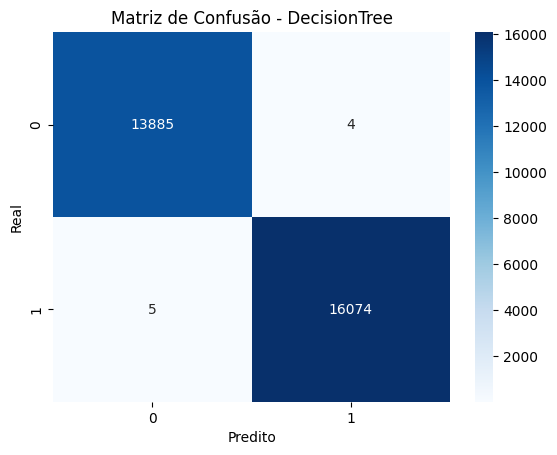


### Treinando RandomForest ###
Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Acurácia: 0.9945
Relatório:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     13889
           1       0.99      1.00      0.99     16079

    accuracy                           0.99     29968
   macro avg       0.99      0.99      0.99     29968
weighted avg       0.99      0.99      0.99     29968



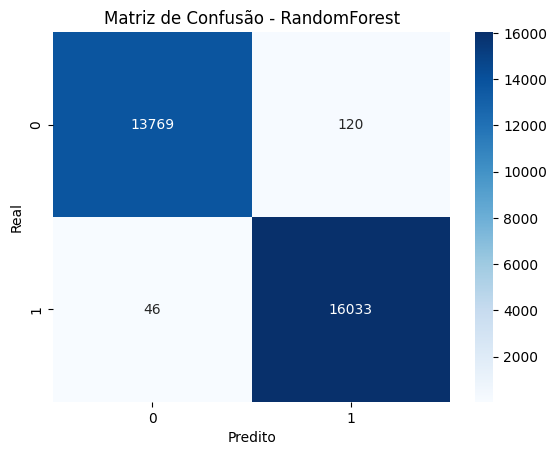


### Treinando LogisticRegression ###
Melhores parâmetros: {'C': 0.1, 'solver': 'lbfgs'}
Acurácia: 0.7189
Relatório:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69     13889
           1       0.73      0.75      0.74     16079

    accuracy                           0.72     29968
   macro avg       0.72      0.72      0.72     29968
weighted avg       0.72      0.72      0.72     29968



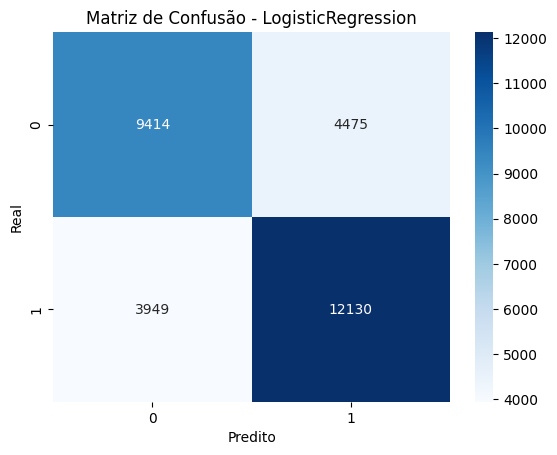


### Treinando XGBoost ###
Melhores parâmetros: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Acurácia: 0.9936
Relatório:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     13889
           1       0.99      1.00      0.99     16079

    accuracy                           0.99     29968
   macro avg       0.99      0.99      0.99     29968
weighted avg       0.99      0.99      0.99     29968



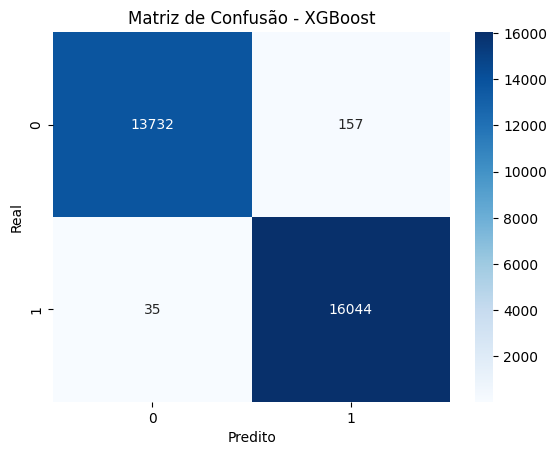

In [238]:

# Função para exibir matriz de confusão
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {title}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

# Treinar, avaliar e plotar
for name in models:
    print(f"\n### Treinando {name} ###")
    clf = GridSearchCV(models[name], param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)

    print(f"Melhores parâmetros: {clf.best_params_}")

    y_pred = clf.predict(X_test)
    print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
    print("Relatório:\n", classification_report(y_test, y_pred))

    plot_confusion(y_test, y_pred, name)

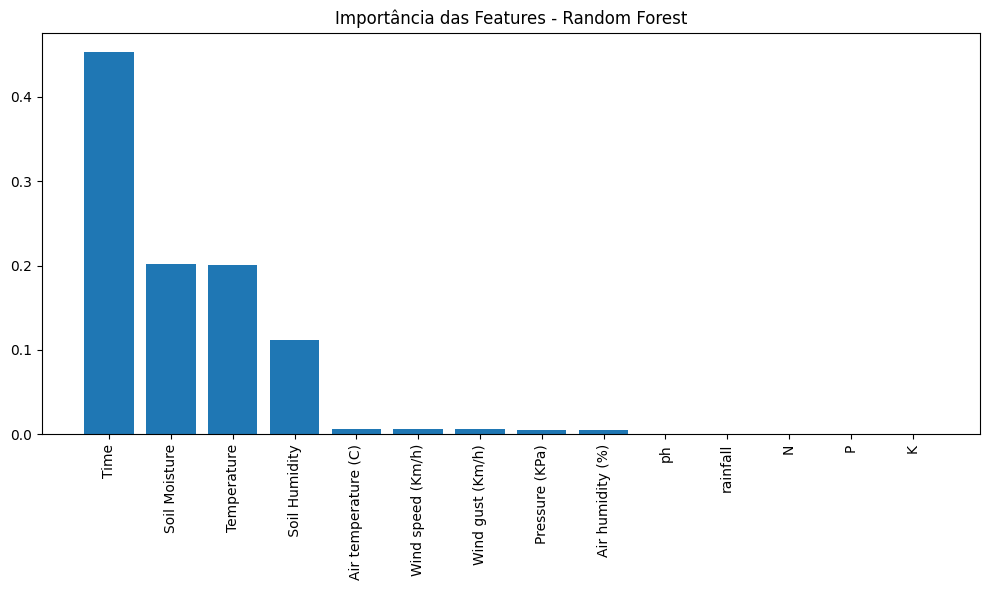

In [241]:

# Define features here
features = X.columns

# Treinar o modelo
rf = RandomForestClassifier()
rf.fit(X, y)

# Importância das features
importances_rf = rf.feature_importances_

# Ordenar
indices_rf = np.argsort(importances_rf)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Importância das Features - Random Forest")
plt.bar(range(len(importances_rf)), importances_rf[indices_rf])
plt.xticks(range(len(importances_rf)), [features[i] for i in indices_rf], rotation=90)
plt.tight_layout()
plt.show()

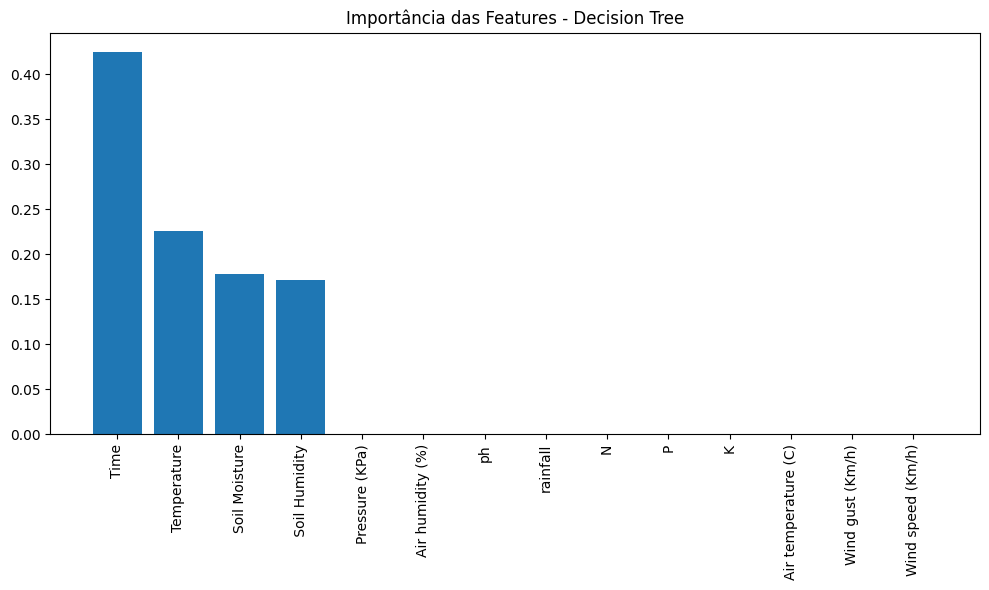

In [242]:

# Treinar o modelo
dt = DecisionTreeClassifier()
dt.fit(X, y)

# Importância das features
importances_dt = dt.feature_importances_

# Ordenar
indices_dt = np.argsort(importances_dt)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Importância das Features - Decision Tree")
plt.bar(range(len(importances_dt)), importances_dt[indices_dt])
plt.xticks(range(len(importances_dt)), [features[i] for i in indices_dt], rotation=90)
plt.tight_layout()
plt.show()


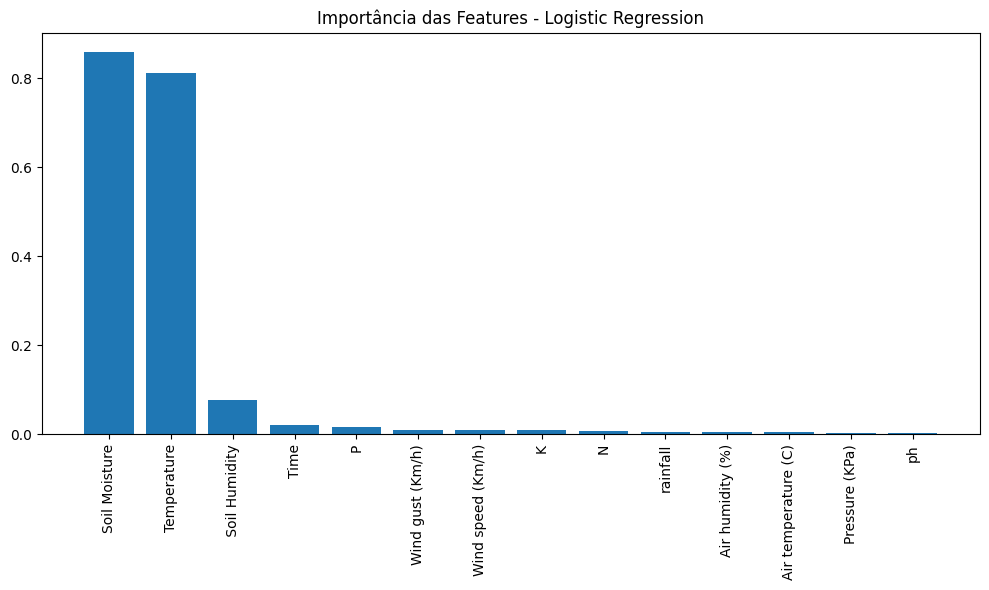

In [254]:
from sklearn.linear_model import LogisticRegression
import numpy as np

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X, y)

importances_lr = np.abs(lr.coef_).flatten()
indices_lr = np.argsort(importances_lr)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importância das Features - Logistic Regression")
plt.bar(range(len(importances_lr)), importances_lr[indices_lr])
plt.xticks(range(len(importances_lr)), [X.columns[i] for i in indices_lr], rotation=90)
plt.tight_layout()
plt.show()


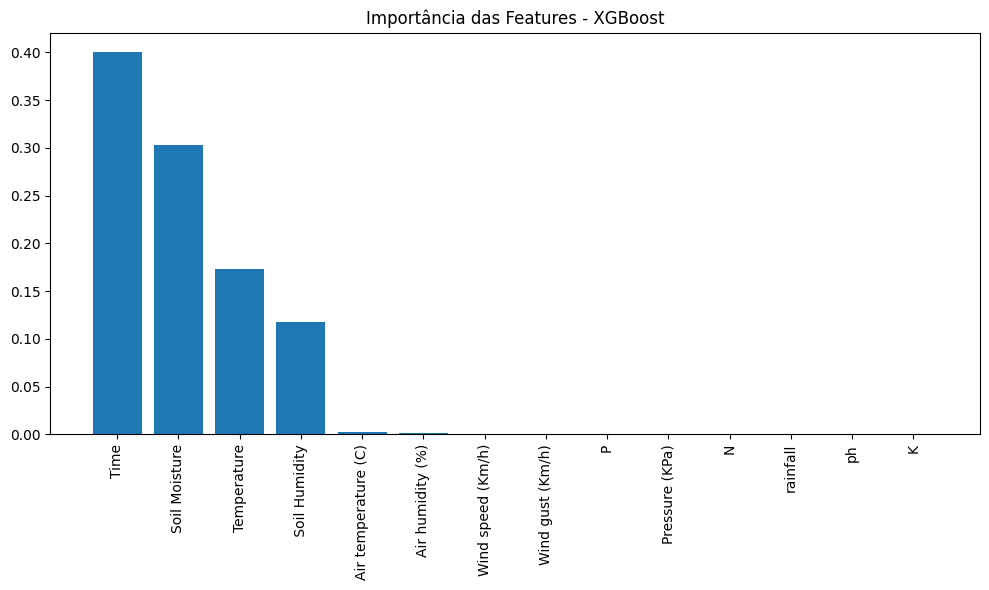

In [253]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X, y)

importances_xgb = xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importância das Features - XGBoost")
plt.bar(range(len(importances_xgb)), importances_xgb[indices_xgb])
plt.xticks(range(len(importances_xgb)), [X.columns[i] for i in indices_xgb], rotation=90)
plt.tight_layout()
plt.show()


### Avaliação

In [259]:
from sklearn.metrics import accuracy_score, classification_report

for name in models:
    print(f"\n### Avaliação Final Simplificada: {name} ###")

    clf = GridSearchCV(models[name], param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    best_model = clf.best_estimator_

    # Previsões
    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    # Métricas
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train, y_pred_train)

    print(f"Acurácia no treino: {acc_train:.4f}")
    print(f"Acurácia no teste: {acc_test:.4f}")

    # Avaliação de possível overfitting
    diff = acc_train - acc_test
    if diff > 0.1:
        print("⚠️ Atenção: Pode haver overfitting (treino muito melhor que teste).")
    else:
        print("✅ Não parece haver overfitting significativo.")

    print("Relatório de classificação no teste:")
    print(classification_report(y_test, y_pred_test))






### Avaliação Final Simplificada: DecisionTree ###
Acurácia no treino: 1.0000
Acurácia no teste: 0.9997
✅ Não parece haver overfitting significativo.
Relatório de classificação no teste:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13889
           1       1.00      1.00      1.00     16079

    accuracy                           1.00     29968
   macro avg       1.00      1.00      1.00     29968
weighted avg       1.00      1.00      1.00     29968


### Avaliação Final Simplificada: RandomForest ###
Acurácia no treino: 1.0000
Acurácia no teste: 0.9945
✅ Não parece haver overfitting significativo.
Relatório de classificação no teste:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     13889
           1       0.99      1.00      0.99     16079

    accuracy                           0.99     29968
   macro avg       0.99      0.99      0.99     29968
weighted avg       0.99  

### Melhor modelo

In [269]:
best_results[name] = {
        'model': best_model,
        'accuracy_test': acc_test,
        'accuracy_train': acc_train,
        'overfitting_diff': diff
    }

# Depois do loop, mostrar o melhor modelo pelo teste
best_model_name = max(best_results, key=lambda k: best_results[k]['accuracy_test'])
best_model_info = best_results[best_model_name]

print("\n\n### Melhor modelo final ###")
print(f"Modelo: {best_model_name}")
print(f"Acurácia no teste: {best_model_info['accuracy_test']:.4f}")
print(f"Acurácia no treino: {best_model_info['accuracy_train']:.4f}")
print(f"Diferença (treino - teste): {best_model_info['overfitting_diff']:.4f}")




### Melhor modelo final ###
Modelo: DecisionTree
Acurácia no teste: 0.9997
Acurácia no treino: 1.0000
Diferença (treino - teste): 0.0003


### Análise de Treinamento do Modelo DecisionTree:

O modelo DecisionTree foi treinado sobre uma base com 99.893 registros e 14 variáveis, com o objetivo de prever a variável binária Status (valores 0 ou 1). Após testes com diferentes algoritmos (DecisionTree, RandomForest, LogisticRegression e XGBoost), o DecisionTree demonstrou melhor desempenho, alcançando:

Acurácia no teste: 99,97%

Acurácia no treino: 100,00%

Diferença entre treino e teste (possível overfitting): 0,03%

Essa diferença indica pouco overfitting, ou seja, o modelo não decorou os dados, mas sim aprendeu padrões reais.

Se quiser, posso ajudar a montar textos assim para os outros modelos também! Quer?
